In [1]:
import random

import numpy as ns
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
    plot_roc_curve,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

import statsmodels.discrete.discrete_model as sm


# Logistic regresion

\begin{equation*}
\hat{p}=\frac{1}{1 + e^{-(\hat{w_{0}} + \hat{w_{1}} * x_{1})...}}
\end{equation*}

### Prepare dataset

In [2]:
df = pd.read_csv('input_data/train.csv', index_col=0)

# Check dataset size
df.shape

(891, 11)

In [3]:
# Show some data
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# Check unique data count
df.agg(['nunique'])

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
nunique,2,3,891,2,88,7,7,681,248,147,3


In [5]:
# Check NaN
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
# Drop not needed columns
# Name, Ticket ---> unique values
# Cabin        ---> too much missing data
df = df.drop(columns=['Name', 'Cabin', 'Ticket'])

In [7]:
# Fill in missing data
# Age      ---> use mediane
# Embarked ---> use random value
df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('median'))
df['Embarked'] = df['Embarked'].fillna(random.choice(df['Embarked'].unique()))

In [8]:
# Change text data to numeric
# df['Sex_num'] = df['Sex'].replace(['female', 'male'], [0, 1])
# df['Embarked_num'] = df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2])
df = pd.concat([df, pd.get_dummies(df['Embarked'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Sex'])], axis=1)

In [9]:
# Add bias column
df['Bias'] = 1

### Prepare train and test set

In [10]:
# Prepare train and test data
X_train, X_test, y_train, y_test = train_test_split(
    df[['Pclass', 'female', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S', 'Bias']],
    df['Survived'], 
    test_size=0.25,
    random_state=42,
)

def get_X(column_names):
    return X_train[column_names], X_test[column_names]


MODELS = [
    ['Bias', 'Pclass', 'female', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S'],
    ['Bias', 'Pclass', 'female', 'Age', 'SibSp', 'Parch'],
    ['Bias', 'Pclass', 'female', 'Age'],
    ['Bias', 'Pclass'],
    ['Bias', 'female'],
    ['Bias', 'Age'],
    ['Bias', 'SibSp'],
    ['Bias', 'Parch'],
    ['Bias', 'Fare'],
    ['Bias', 'C', 'Q', 'S'],     
]


### Fit with statsmodels

In [11]:
# accuracy_score ---> evaluates prediction
# recall_score   ---> evaluates finding positive values 


def fit_model(columns):
    print(f'Predict based on: {" - ".join(columns)}')
    print('\n')
    
    X_train, X_test = get_X(columns)
    logit = sm.Logit(y_train, X_train, max_iter=10_000)
    f = logit.fit()
    
    y_train_pred = f.predict(X_train)
    acc_train = accuracy_score(
        y_true=y_train,
        y_pred=y_train_pred.apply(lambda x: 1 if x > 0.5 else 0)
    )
    rec_train = recall_score(
        y_true=y_train,
        y_pred=y_train_pred.apply(lambda x: 1 if x > 0.1 else 0)
    )
    
    y_test_pred = f.predict(X_test)
    acc_test = accuracy_score(
        y_true=y_test,
        y_pred=y_test_pred.apply(lambda x: 1 if x > 0.5 else 0)
    )
    rec_test = recall_score(
        y_true=y_train,
        y_pred=y_train_pred.apply(lambda x: 1 if x > 0.1 else 0)
    )
    
    # print(f.params)
    # print(f.summary())
    # print('\n')
    print(f'Accuracy score train {acc_train}; Recall train score {rec_train}')
    print(f'Acc test {acc_test}; Recall test score {rec_test}')
    print('-' * 20)
    print('\n')

    
for model in MODELS:
    fit_model(model)


Predict based on: Bias - Pclass - female - Age - SibSp - Parch - Fare - C - Q - S


Optimization terminated successfully.
         Current function value: 0.448227
         Iterations 6
Accuracy score train 0.7994011976047904; Recall train score 0.9525691699604744
Acc test 0.8071748878923767; Recall test score 0.9525691699604744
--------------------


Predict based on: Bias - Pclass - female - Age - SibSp - Parch


Optimization terminated successfully.
         Current function value: 0.452413
         Iterations 6
Accuracy score train 0.7829341317365269; Recall train score 0.9486166007905138
Acc test 0.8161434977578476; Recall test score 0.9486166007905138
--------------------


Predict based on: Bias - Pclass - female - Age


Optimization terminated successfully.
         Current function value: 0.459984
         Iterations 6
Accuracy score train 0.7964071856287425; Recall train score 0.924901185770751
Acc test 0.7982062780269058; Recall test score 0.924901185770751
-----------------

### Fit with sklearn

In [12]:
def fit_model(columns):
    print(f'Predict based on: {" - ".join(columns)}')
    
    X_train, X_test = get_X(columns)
    m = LogisticRegression(C=1e5, max_iter=10_000)
    f = m.fit(X_train, y_train)
    
    y_train_pred = f.predict(X_train)
    acc_train = accuracy_score(
        y_true=y_train,
        y_pred=y_train_pred
    )
    y_test_pred = f.predict(X_test)
    acc_test = accuracy_score(
        y_true=y_test,
        y_pred=y_test_pred
    )

    print(f'Acc train {acc_train}')
    print(f'Acc test {acc_test}')
    print('-' * 20)
    print('\n')

    
for model in MODELS:
    fit_model(model)


Predict based on: Bias - Pclass - female - Age - SibSp - Parch - Fare - C - Q - S
Acc train 0.7994011976047904
Acc test 0.8071748878923767
--------------------


Predict based on: Bias - Pclass - female - Age - SibSp - Parch
Acc train 0.7829341317365269
Acc test 0.8161434977578476
--------------------


Predict based on: Bias - Pclass - female - Age
Acc train 0.7964071856287425
Acc test 0.7982062780269058
--------------------


Predict based on: Bias - Pclass
Acc train 0.6721556886227545
Acc test 0.6995515695067265
--------------------


Predict based on: Bias - female
Acc train 0.7874251497005988
Acc test 0.7847533632286996
--------------------


Predict based on: Bias - Age
Acc train 0.6212574850299402
Acc test 0.600896860986547
--------------------


Predict based on: Bias - SibSp
Acc train 0.6212574850299402
Acc test 0.600896860986547
--------------------


Predict based on: Bias - Parch
Acc train 0.6152694610778443
Acc test 0.5874439461883408
--------------------


Predict based o

### Evaluate prediction

In [13]:
X_train, X_test = get_X(['Bias', 'Pclass', 'female', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S'])
m = LogisticRegression(C=1e5, max_iter=10_000)
f = m.fit(X_train, y_train)
    
y_train_pred = f.predict(X_train)
y_test_pred = f.predict(X_test)


[[115  19]
 [ 24  65]]


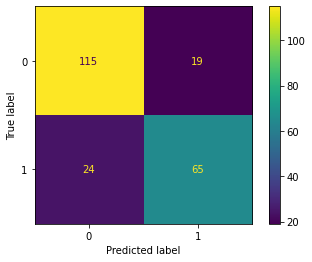

In [14]:
# Confusion matrix
cm = confusion_matrix(
    y_pred=y_test_pred,
    y_true=y_test,
)
print(cm)

plot_confusion_matrix(f, X_test, y_test, normalize=None)

In [15]:
print(
    f'Accuracy: {accuracy_score(y_pred=y_test_pred, y_true=y_test)}\n'
    f'Precision: {precision_score(y_pred=y_test_pred, y_true=y_test)}\n'
    f'Recall {recall_score(y_pred=y_test_pred, y_true=y_test)}\n'
)

Accuracy: 0.8071748878923767
Precision: 0.7738095238095238
Recall 0.7303370786516854



In [16]:
# DummyClassifier - stratified (based on distribution)
df = DummyClassifier(strategy='stratified')
f = df.fit(X_train, y_train)
y_dummy = f.predict(X_test)

print(
    f'Accuracy: {accuracy_score(y_pred=y_dummy, y_true=y_test)}\n'
    f'Precision: {precision_score(y_pred=y_dummy, y_true=y_test)}\n'
    f'Recall {recall_score(y_pred=y_dummy, y_true=y_test)}\n'
)

Accuracy: 0.49327354260089684
Precision: 0.36046511627906974
Recall 0.34831460674157305



In [17]:
# DummyClassifier - uniform (random)
df = DummyClassifier(strategy='uniform')
f = df.fit(X_train, y_train)
y_dummy = f.predict(X_test)

print(
    f'Accuracy: {accuracy_score(y_pred=y_dummy, y_true=y_test)}\n'
    f'Precision: {precision_score(y_pred=y_dummy, y_true=y_test)}\n'
    f'Recall {recall_score(y_pred=y_dummy, y_true=y_test)}\n'
)

Accuracy: 0.4977578475336323
Precision: 0.3838383838383838
Recall 0.42696629213483145



In [18]:
# DummyClassifier - prior (most frequent)
df = DummyClassifier(strategy='prior')
f = df.fit(X_train, y_train)
y_dummy = f.predict(X_test)

print(
    f'Accuracy: {accuracy_score(y_pred=y_dummy, y_true=y_test)}\n'
    f'Precision: {precision_score(y_pred=y_dummy, y_true=y_test, zero_division=True)}\n'
    f'Recall {recall_score(y_pred=y_dummy, y_true=y_test)}\n'
)

Accuracy: 0.600896860986547
Precision: 1.0
Recall 0.0



Optimization terminated successfully.
         Current function value: 0.448227
         Iterations 6


(0.0, 1.0, 0.0, 1.0)

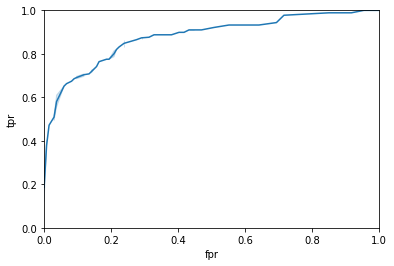

In [19]:
# WIP: ROC manual

fpr = []
tpr = []


X_train, X_test = get_X(['Bias', 'Pclass', 'female', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q'])
logit = sm.Logit(y_train, X_train, max_iter=10_000)
f = logit.fit()
    
y_pred = f.predict(X_test)

for thr in range(0, 101):
    y_pred_thr = y_pred.apply(lambda x: 1 if x > (thr/100) else 0)
    cm = confusion_matrix(
        y_pred=y_pred_thr,
        y_true=y_test        
    )
    fpr.append(cm[0][1]/(cm[0][0] + cm[0][1]))
    tpr.append(cm[1][1]/(cm[1][1] + cm[1][0]))


sns.lineplot(
    y='tpr',
    x='fpr',
    data={
        'tpr': tpr,        
        'fpr': fpr, 
    }
)
plt.axis([0, 1, 0, 1])

<AxesSubplot:xlabel='fpr', ylabel='tpr'>

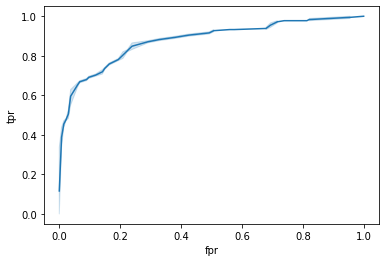

In [20]:
myfpr, mytpr, mythr = roc_curve(
    y_score=y_pred,
    y_true=y_test,
)

sns.lineplot(
    y='tpr',
    x='fpr',
    data={
        'tpr': mytpr,        
        'fpr': myfpr, 
    }
)

